In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [79]:
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]  
data.columns = ['label', 'message']

In [80]:
print(data.head())
print(data['label'].value_counts())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64


In [81]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


(5572, 2)

In [82]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [83]:
import zipfile
import os

resource_path = '/usr/share/nltk_data/corpora'
wordnet_zip = '/usr/share/nltk_data/corpora/wordnet.zip'


with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
    zip_ref.extractall(resource_path) 

In [84]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [85]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [86]:
data['processed_message'] = data['message'].apply(preprocess_text)

In [87]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['processed_message']).toarray()
y = data['label'].apply(lambda x: 1 if x == 'spam' else 0)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [90]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [91]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

In [92]:
param_grid = {'C': [0.1, 1, 10, 100], 'solver': ['liblinear', 'saga']}
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)
y_pred_grid = grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.1s
[CV] END .................................C=0.1, solver=saga; total time=   2.8s
[CV] END .................................C=0.1, solver=saga; total time=   2.6s
[CV] END .................................C=0.1, solver=saga; total time=   2.4s
[CV] END .................................C=0.1, solver=saga; total time=   2.6s
[CV] END .................................C=0.1, solver=saga; total time=   2.4s
[CV] END ..............................C=1, solver=liblinear; total time=   0.1s
[CV] END ..............................C=1, solve

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=100, solver=saga; total time=  14.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=100, solver=saga; total time=  14.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=100, solver=saga; total time=  14.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .................................C=100, solver=saga; total time=  14.6s
[CV] END .................................C=100, solver=saga; total time=  14.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [93]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

Model: Naive Bayes
Accuracy: 0.972488038277512

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1453
           1       0.99      0.79      0.88       219

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672


Confusion Matrix:
 [[1452    1]
 [  45  174]]


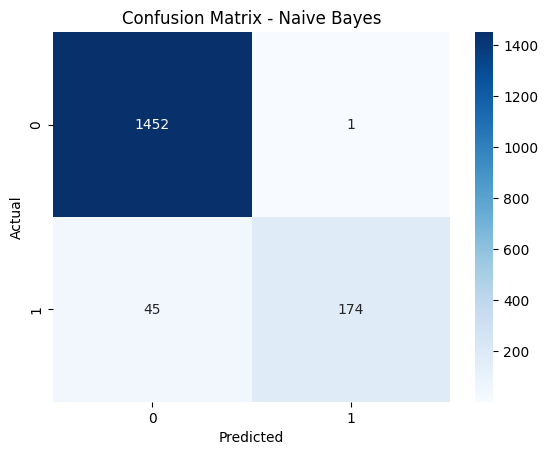

Model: SVM
Accuracy: 0.9754784688995215

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      1453
           1       0.99      0.82      0.90       219

    accuracy                           0.98      1672
   macro avg       0.98      0.91      0.94      1672
weighted avg       0.98      0.98      0.97      1672


Confusion Matrix:
 [[1451    2]
 [  39  180]]


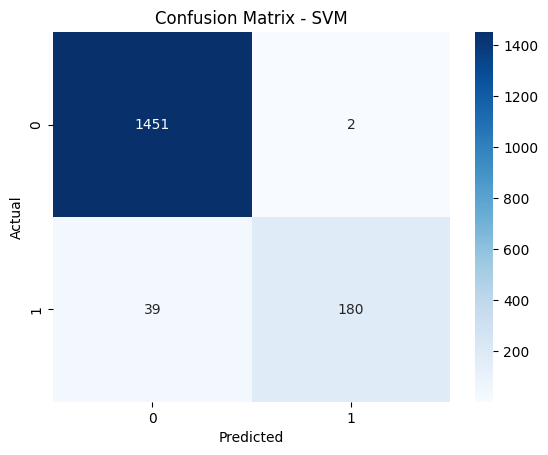

Model: Logistic Regression
Accuracy: 0.9551435406698564

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      1453
           1       0.96      0.68      0.80       219

    accuracy                           0.96      1672
   macro avg       0.96      0.84      0.89      1672
weighted avg       0.96      0.96      0.95      1672


Confusion Matrix:
 [[1447    6]
 [  69  150]]


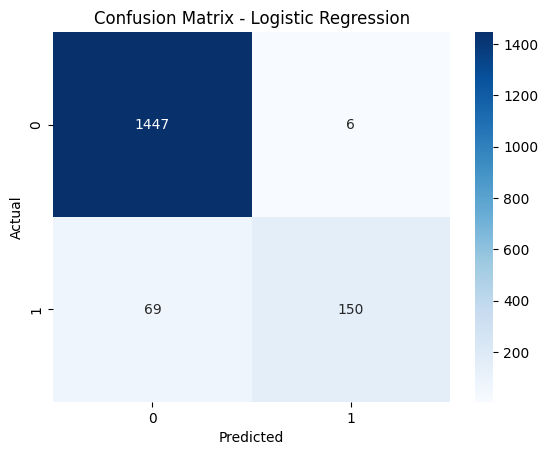

Model: Logistic Regression (Tuned)
Accuracy: 0.9802631578947368

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.99      0.86      0.92       219

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672


Confusion Matrix:
 [[1451    2]
 [  31  188]]


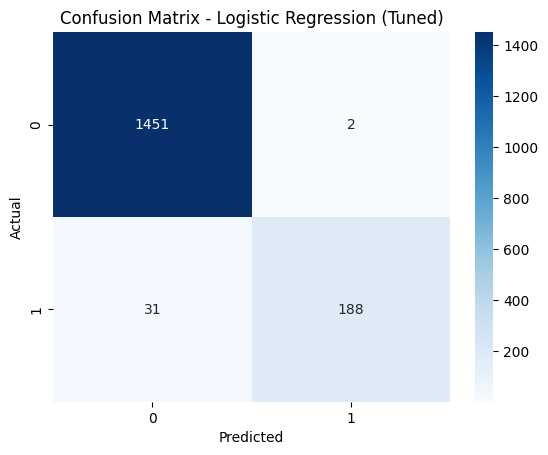

In [94]:
evaluate_model(y_test, y_pred_nb, "Naive Bayes")
evaluate_model(y_test, y_pred_svm, "SVM")
evaluate_model(y_test, y_pred_logreg, "Logistic Regression")
evaluate_model(y_test, y_pred_grid, "Logistic Regression (Tuned)")

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [96]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(data['processed_message'])
X_nn = tokenizer.texts_to_sequences(data['processed_message'])
X_nn = pad_sequences(X_nn, maxlen=100)

In [97]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y, test_size=0.3, random_state=42)

In [98]:
model = Sequential()
model.add(Embedding(input_dim=3000, output_dim=128))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [99]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_nn, y_train_nn, epochs=5, batch_size=32, validation_data=(X_test_nn, y_test_nn))

Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8651 - loss: 0.3029 - val_accuracy: 0.9713 - val_loss: 0.1400
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.1189 - val_accuracy: 0.9856 - val_loss: 0.1215
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0925 - val_accuracy: 0.9773 - val_loss: 0.1357
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0829 - val_accuracy: 0.9821 - val_loss: 0.1209
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9973 - loss: 0.0794 - val_accuracy: 0.9856 - val_loss: 0.1143


In [100]:
y_pred_nn = (model.predict(X_test_nn) > 0.5).astype("int32")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: Neural Network
Accuracy: 0.9856459330143541

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1453
           1       0.99      0.90      0.94       219

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.99      1672


Confusion Matrix:
 [[1451    2]
 [  22  197]]


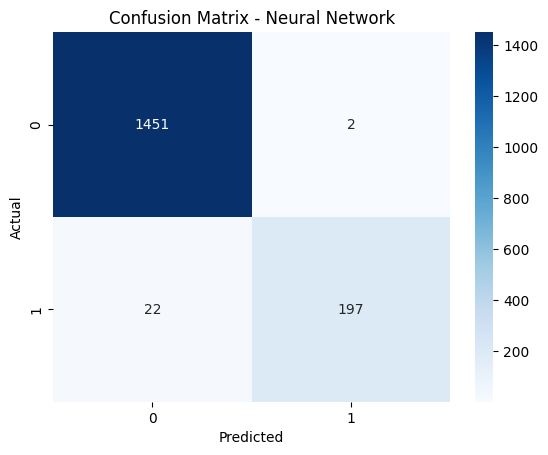

In [101]:
evaluate_model(y_test_nn, y_pred_nn, "Neural Network")

In [102]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

In [103]:
voting_clf = VotingClassifier(estimators=[
    ('nb', nb_model), 
    ('svm', svm_model), 
    ('logreg', logreg_model)], voting='hard')

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

In [104]:
stacking_clf = StackingClassifier(estimators=[
    ('nb', nb_model), 
    ('svm', svm_model)], final_estimator=LogisticRegression())

In [105]:
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)

Model: Voting Classifier
Accuracy: 0.9712918660287081

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1453
           1       0.99      0.79      0.88       219

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672


Confusion Matrix:
 [[1451    2]
 [  46  173]]


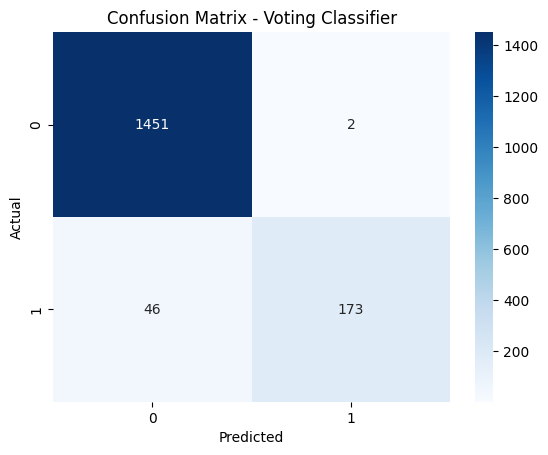

Model: Stacking Classifier
Accuracy: 0.9838516746411483

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.98      0.89      0.94       219

    accuracy                           0.98      1672
   macro avg       0.98      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672


Confusion Matrix:
 [[1450    3]
 [  24  195]]


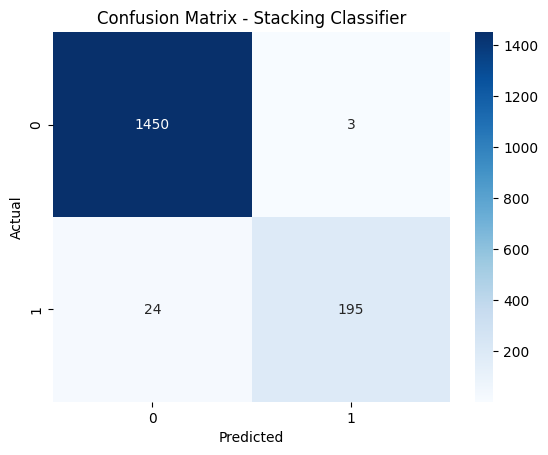

In [106]:
evaluate_model(y_test, y_pred_voting, "Voting Classifier")
evaluate_model(y_test, y_pred_stacking, "Stacking Classifier")

In [159]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def leaky_relu(Z):
    return np.where(Z > 0, Z, Z * 0.01)

def leaky_relu_derivative(Z):
    return np.where(Z > 0, 1, 0.01)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [229]:
input_size = X_train.shape[1]
hidden_size = 30
output_size = 1 
learning_rate = 1
epochs = 1000

In [230]:
W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
b2 = np.zeros((1, output_size))

In [231]:
for epoch in range(epochs):
    
    Z1 = np.dot(X_train, W1) + b1
    A1 = leaky_relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    
    y_train_np = y_train.values.reshape(-1, 1)

    m = y_train.shape[0]
    loss = -(1/m) * np.sum(y_train_np * np.log(A2 + 1e-8) + (1 - y_train_np) * np.log(1 - A2 + 1e-8))
    
    dZ2 = A2 - y_train_np.reshape(-1, 1)
    dW2 = (1/m) * np.dot(A1.T, dZ2)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * leaky_relu_derivative(A1)
    dW1 = (1/m) * np.dot(X_train.T, dZ1)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs} - Loss: {loss}')

Epoch 0/1000 - Loss: 0.7066829684796458
Epoch 100/1000 - Loss: 0.2415765346995654
Epoch 200/1000 - Loss: 0.08118479331221624
Epoch 300/1000 - Loss: 0.046414710464859725
Epoch 400/1000 - Loss: 0.03079275726942011
Epoch 500/1000 - Loss: 0.02192825602019602
Epoch 600/1000 - Loss: 0.016496961836860932
Epoch 700/1000 - Loss: 0.012972977122682753
Epoch 800/1000 - Loss: 0.010546740550576413
Epoch 900/1000 - Loss: 0.008795418021510496


In [223]:
def evaluate_model_NN(X_test, y_test, W1, b1, W2, b2):
    
    Z1_test = np.dot(X_test, W1) + b1
    A1_test = leaky_relu(Z1_test)
    Z2_test = np.dot(A1_test, W2) + b2
    A2_test = sigmoid(Z2_test)
    
    y_pred = (A2_test > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - NN')
    plt.show()

    return accuracy, y_pred

Accuracy: 98.03%

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       0.98      0.86      0.92       219

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672


Confusion Matrix:
 [[1450    3]
 [  30  189]]


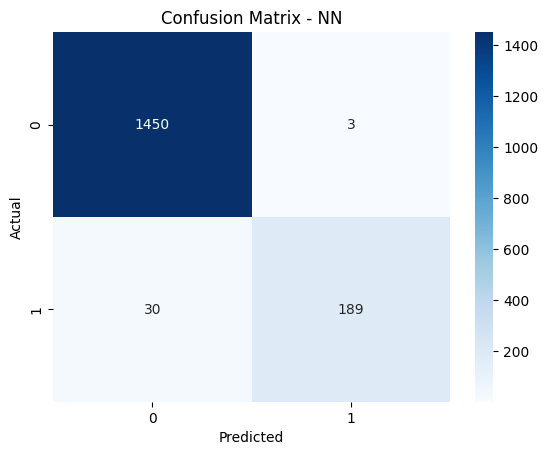

In [232]:
accuracy, y_pred = evaluate_model_NN(X_test, y_test, W1, b1, W2, b2)